In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact, Visualization
from scipy.stats import spearmanr, kruskal

%matplotlib inline

In [8]:
cd ../200608_Elsayed_Lowry-1101/reanalysis-2/

/Users/johnsterrett/Research-Projects/Boulder/Chemobrain/200608_Elsayed_Lowry-1101/reanalysis-2


In [12]:
cp ../insertion-tree.qza insertion-tree.qza

In [14]:
ls

expr-group-metadata.tsv    nobloom_table.qza
filt-seq-taxa-barplot.qzv  samp-filt-seq-table.qza
insertion-tree.qza         taxonomy-gg.qza
nobloom_metadata.tsv


# Diversity
### Start by looking at reads/feature

>qiime feature-table summarize \
--i-table nobloom_table.qza \
--o-visualization nobloom_table.qzv \

In [16]:
viz = Visualization.load("nobloom_table.qzv")
viz

<visualization: Visualization uuid: 7af54aa8-f056-4148-abd7-d5b1249ab6be>

**The lowest number of reads above 10,000 is 13,056, so I will rarefy to 13,055.**

>qiime diversity core-metrics-phylogenetic \
--i-table nobloom_table.qza \
--i-phylogeny insertion-tree.qza \
--p-sampling-depth 13055 \
--m-metadata-file nobloom_metadata.tsv \
--output-dir core-diversity-results/

In [21]:
mkdir diversity-stats-results/

>qiime diversity alpha-group-significance \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-group.qzv

In [23]:
Visualization.load("diversity-stats-results/faith-group.qzv")

<visualization: Visualization uuid: 148091e8-02fa-4218-a49e-1628f2e9db89>

### Alpha group results
 - Chemotherapy
     - Not significant
     - p=0.267
     - H=1.23
 - CES-D
     - Not significant
     - p=0.091
     - H=2.86
 - FACT-Cog
     - Not significant
     - p=0.110
     - H=2.453
 - Stress scale
     - Not significant
     - p=0.498
     - H=0.458
 - PROMIS
     - Not significant
     - p=0.620
     - H=0.957

In [25]:
!qiime diversity alpha-correlation \
--i-alpha-diversity core-diversity-results/faith_pd_vector.qza \
--m-metadata-file nobloom_metadata.tsv \
--o-visualization diversity-stats-results/faith-corr.qzv

Saved Visualization to: diversity-stats-results/faith-corr.qzv


In [26]:
Visualization.load("diversity-stats-results/faith-corr.qzv")

<visualization: Visualization uuid: 7c5dc032-b053-449d-9906-83f471760e58>

### Alpha Correlation results
 - Time difference
     - Not significant
     - p=0.085
     - Spearman r = 0.510
 - CES-D Total
     - SIGNIFICANT
     - p=0.033
     - Spearman r = -0.3903
 - FACT-Cog total
     - Not significant
     - p=0.116
     - Spearman r=0.2929
 - Stress scale
     - Not significant
     - p=0.247
     - Spearman r = -0.2182
 - PROMIS
     - Not significant
     - p=0.0648
     - Spearman r = -0.3414


In [259]:
metadata = pd.read_csv("nobloom_metadata.tsv", sep="\t", index_col="sampleid")

faith = Artifact.load("core-diversity-results/faith_pd_vector.qza").view(pd.Series)
faith.index = faith.index.astype(int)

time_faith = pd.concat([ faith, 
                         metadata[["Chemotherapy", "Time difference"]] ], 
                       axis=1)

#Make controls time diff=0, get rid of negative time diff
time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control", "Time difference"] = 0

time_faith.loc[(time_faith["Chemotherapy"]=="Breast Cancer") & 
               (time_faith["Time difference"] < 0),
                 "Time difference"] = np.NaN

#Drop nan faith values
time_faith.dropna(inplace=True)

time_faith_bc = time_faith[time_faith["Chemotherapy"]=="Breast Cancer"]

In [260]:
fit = np.polyfit(x = np.log(time_faith_bc["Time difference"]+0.01),
                 y = time_faith_bc["faith_pd"],
                 deg=1)

In [75]:
mkdir Figures

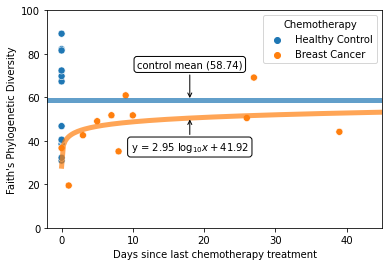

In [261]:
x = np.arange(0,45,0.25)+0.01
logy = fit[0] * np.log(x) + fit[1]


ax = sns.scatterplot(y="faith_pd",
                     x="Time difference",
                     data=time_faith,
                     hue="Chemotherapy",
                     x_jitter=True,
                     s=50)

ax.axhline(time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean(),
           c="tab:blue",
           lw=5,
           alpha=0.7)

ax.plot(x,logy, lw=5, alpha=0.7, c="tab:orange")



annot_coords = (18, fit[0] * np.log(20) + fit[1])

ax.annotate("y = " + str(round(fit[0],2)) + r" $\log{_{10}}{x} + $" + str(round(fit[1], 2)), 
            xy=annot_coords, xytext=(18, fit[0] * np.log(20) + fit[1]-15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

grp2_mean = time_faith.loc[time_faith["Chemotherapy"]=="Healthy Control","faith_pd"].mean()

ax.annotate("control mean (" + str(round(grp2_mean,2)) + ")", 
            xy=(18, grp2_mean), 
            xytext=(18, grp2_mean + 15),
            ha="center", bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="->"))

ax.set_ylim(0,100)
ax.set_xlim(-2,45)
ax.set_ylabel("Faith's Phylogenetic Diversity")
ax.set_xlabel("Days since last chemotherapy treatment")

plt.savefig("Figures/faith_log_fit_annotated.pdf")
plt.show()

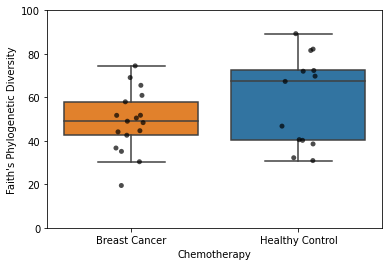

In [262]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                 y=faith,
                 showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=faith,
              palette=["black"]*2,
              alpha=0.7)

ax.set_ylim(0,100)
ax.set_ylabel("Faith's Phylogenetic Diversity")

plt.savefig("Figures/faith_chemo.pdf")
plt.show()

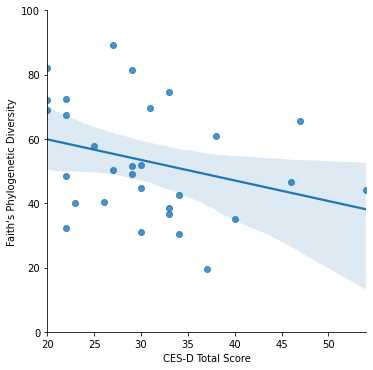

In [266]:
g = sns.lmplot(x="cesd_total",
                y="faith_pd",
                data=pd.concat([faith, metadata["cesd_total"]],
                              axis=1))

g.axes[0,0].set_ylim(0,100)
g.axes[0,0].set_ylabel("Faith's Phylogenetic Diversity")

g.axes[0,0].set_xlabel("CES-D Total Score")

plt.savefig("Figures/faith_cesd_corr.pdf")
plt.show()

### Beta Diversity

In [267]:
from skbio.stats.distance import mantel, permanova, DistanceMatrix
from scipy.spatial.distance import pdist, cdist

In [268]:
wuni = Artifact.load("core-diversity-results/weighted_unifrac_distance_matrix.qza").view(DistanceMatrix)
uuni = Artifact.load("core-diversity-results/unweighted_unifrac_distance_matrix.qza").view(DistanceMatrix)

In [269]:
metadata_beta = metadata
metadata_beta.index = metadata_beta.index.astype(str)
metadata_beta = metadata_beta.loc[list(wuni.ids)]

### PERMANOVA
#### Weighted UniFrac

In [270]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(wuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print(" SIGNIFICANT")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.816605
p-value                       0.551
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.12314
p-value                       0.309
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic             0.396761
p-value                       0.969
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method name              

#### Unweighted UniFrac

In [271]:
for var in ["Chemotherapy", 
            "fact_c_r_imp_total_categorical",
            "stress_scale_total_categorical", 
            "cesd_total_categorical",
            "promis_tscore_categorical"]:
    perm = permanova(uuni, 
                    metadata_beta,
                    column=var)
    
    print("\n" + var)
    if perm[5] <= 0.05:
        print("**SIGNIFICANT**")
    print(perm)


Chemotherapy
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.07811
p-value                       0.245
number of permutations          999
Name: PERMANOVA results, dtype: object

fact_c_r_imp_total_categorical
**SIGNIFICANT**
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              1.51465
p-value                       0.017
number of permutations          999
Name: PERMANOVA results, dtype: object

stress_scale_total_categorical
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      30
number of groups                  2
test statistic              0.80454
p-value                       0.937
number of permutations          999
Name: PERMANOVA results, dtype: object

cesd_total_categorical
method na

### Mantel
#### weighted UniFrac

In [272]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_wuni = DistanceMatrix(wuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_wuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.15358421848850945
p value:  0.446

variable:  fact_c_total
significant:  False
corr coef:  0.002951707445232093
p value:  0.971

variable:  cesd_total
significant:  False
corr coef:  0.06348284364350958
p value:  0.457

variable:  promis_rawscore
significant:  False
corr coef:  -0.09411761358093827
p value:  0.282

variable:  stress_scale_total
significant:  False
corr coef:  -0.07729954779591705
p value:  0.219


#### Unweighted UniFrac

In [273]:
for var in ["Time difference",
            "fact_c_total",
            "cesd_total",
            "promis_rawscore",
            "stress_scale_total"]:
    
    #initialize empty distance matrix
    dat = metadata_beta[var].dropna()
    dim = dat.shape[0]
    distm = np.empty((dim, dim))
    
    #fill distance matrix
    for i in range(dim):
        for j in range(dim):
            distm[i,j] = np.abs(dat.iloc[i]-dat.iloc[j])

    distm = DistanceMatrix(distm, ids=dat.index)

    #filter where we don't have data
    var_uuni = DistanceMatrix(uuni.to_data_frame().loc[dat.index,dat.index], 
                              ids=dat.index)
    #do the mantel
    man = mantel(var_uuni, 
                distm,
                method="spearman")

    print("\nvariable: ", var)
    print("significant: ", man[1]<0.05)
    print("corr coef: ", man[0])
    print("p value: ", man[1])


variable:  Time difference
significant:  False
corr coef:  0.07642638277486448
p value:  0.668

variable:  fact_c_total
significant:  False
corr coef:  0.10572806820942689
p value:  0.16

variable:  cesd_total
significant:  False
corr coef:  0.0008239026282835701
p value:  0.993

variable:  promis_rawscore
significant:  False
corr coef:  0.01658151414238586
p value:  0.861

variable:  stress_scale_total
significant:  False
corr coef:  -0.03324645393547799
p value:  0.639


## Differential abundance

In [201]:
! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 2 \
--o-collapsed-table L2-nobloom-table.qza

Saved FeatureTable[Frequency] to: L2-nobloom-table.qza


In [202]:
! qiime taxa collapse \
--i-table nobloom_table.qza \
--i-taxonomy taxonomy-gg.qza \
--p-level 6 \
--o-collapsed-table L6-nobloom-table.qza

Saved FeatureTable[Frequency] to: L6-nobloom-table.qza


In [205]:
! qiime composition add-pseudocount \
--i-table L2-nobloom-table.qza \
--o-composition-table L2-nobloom-pseudo-table.qza

Saved FeatureTable[Composition] to: L2-nobloom-pseudo-table.qza


In [206]:
! qiime composition add-pseudocount \
--i-table L6-nobloom-table.qza \
--o-composition-table L6-nobloom-pseudo-table.qza

Saved FeatureTable[Composition] to: L6-nobloom-pseudo-table.qza


In [208]:
! qiime composition ancom \
--i-table L2-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L2-chemo.qzv

Saved Visualization to: ANCOM-L2-chemo.qzv


In [209]:
! qiime composition ancom \
--i-table L6-nobloom-pseudo-table.qza \
--m-metadata-file nobloom_metadata.tsv \
--m-metadata-column "Chemotherapy" \
--o-visualization ANCOM-L6-chemo.qzv

Saved Visualization to: ANCOM-L6-chemo.qzv


#### NO SIGNIFICANT RESULTS FROM ANCOM

### Taxa correlations

In [274]:
L2 = Artifact.load("L2-nobloom-table.qza").view(pd.DataFrame)

L2mat = np.matrix(L2)
L2mat /= L2mat.sum(axis=1)

L2 = pd.DataFrame(L2mat,
                  columns=L2.columns,
                  index=L2.index)

In [275]:
for col in L2.columns:
    spear = spearmanr(metadata["fact_c_total"],
                      L2[col])
    
    if spear.pvalue < 0.05:
        print("SIGNIFICANT:")
    print(col, spear)

k__Archaea;p__Euryarchaeota SpearmanrResult(correlation=0.053398285092415676, pvalue=0.7716208536223468)
k__Bacteria;__ SpearmanrResult(correlation=0.00495347671714674, pvalue=0.9785344195744046)
k__Bacteria;p__ SpearmanrResult(correlation=0.29795093816833756, pvalue=0.09766741711407034)
k__Bacteria;p__Actinobacteria SpearmanrResult(correlation=-0.06729006686386008, pvalue=0.714424189864929)
k__Bacteria;p__Bacteroidetes SpearmanrResult(correlation=-0.007334067233118264, pvalue=0.9682226176176119)
k__Bacteria;p__Cyanobacteria SpearmanrResult(correlation=0.26400645206450624, pvalue=0.14426886968436842)
k__Bacteria;p__Firmicutes SpearmanrResult(correlation=-0.015768244551204267, pvalue=0.9317406945378783)
k__Bacteria;p__Fusobacteria SpearmanrResult(correlation=0.04412469905425526, pvalue=0.8104909085348513)
k__Bacteria;p__Lentisphaerae SpearmanrResult(correlation=0.18812509191329121, pvalue=0.30249438587549515)
k__Bacteria;p__Proteobacteria SpearmanrResult(correlation=0.022735608422666618

In [299]:
L2.loc[:,L2.mean(axis=0)>0.005]

,k__Bacteria;p__Actinobacteria,k__Bacteria;p__Bacteroidetes,k__Bacteria;p__Firmicutes,k__Bacteria;p__Proteobacteria,k__Bacteria;p__Tenericutes,k__Bacteria;p__Verrucomicrobia
1,0.066813,0.124315,0.755203,0.053669,0.000000,0.000000
10,0.023347,0.435018,0.516745,0.008891,0.010553,0.000000
12,0.011258,0.271776,0.706959,0.009946,0.000000,0.000000
14,0.033363,0.095912,0.854832,0.003232,0.007552,0.000000
15,0.024392,0.463274,0.481043,0.014872,0.006833,0.002452
17,0.000560,0.591117,0.371614,0.036708,0.000000,0.000000
19,0.062944,0.266182,0.643069,0.021311,0.004989,0.000000
21,0.003196,0.527444,0.435956,0.011693,0.000000,0.000507
22,0.021050,0.384769,0.585339,0.008842,0.000000,0.000000
23,0.008687,0.539383,0.419367,0.032563,0.000000,0.000000


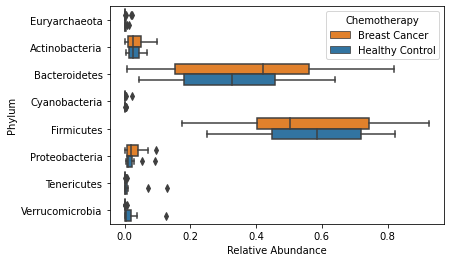

In [303]:


L2chemo = pd.concat([L2.loc[:,L2.mean(axis=0)>0.001], 
                     metadata["Chemotherapy"]],
                    axis=1)

L2chemo = pd.melt(L2chemo, id_vars="Chemotherapy")

L2chemo["Phylum"] = L2chemo["variable"].apply(lambda x: x.split("p__")[1])

ax = sns.boxplot(x="value",
                y="Phylum",
                hue="Chemotherapy",
                data=L2chemo,
                palette=["tab:orange","tab:blue"])

ax.set_xlabel("Relative Abundance")

plt.savefig("Figures/Phyla-boxplots.pdf")
plt.show()

### Akkermansia

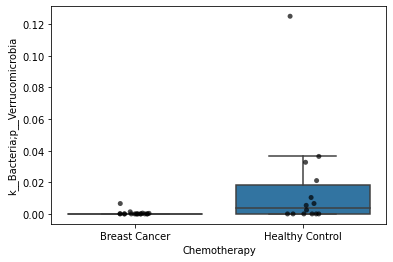

In [304]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L2["k__Bacteria;p__Verrucomicrobia"],
                showfliers=False,
                 palette=["tab:orange", "tab:blue"])

sns.stripplot(x=metadata["Chemotherapy"],
              y=L2["k__Bacteria;p__Verrucomicrobia"],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)
plt.show()

In [305]:
kruskal(L2.loc[metadata["Chemotherapy"]=="Breast Cancer","k__Bacteria;p__Verrucomicrobia"],
        L2.loc[metadata["Chemotherapy"]=="Healthy Control","k__Bacteria;p__Verrucomicrobia"])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)

In [306]:
L6 = Artifact.load("L6-nobloom-table.qza").view(pd.DataFrame)

L6mat = np.matrix(L6)
L6mat /= L6mat.sum(axis=1)

L6 = pd.DataFrame(L6mat,
                  columns=L6.columns,
                  index=L6.index)

In [307]:
list(filter(lambda x: "akkermansia" in x.lower(), L6.columns))

['k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia']

In [308]:
akker = 'k__Bacteria;p__Verrucomicrobia;c__Verrucomicrobiae;o__Verrucomicrobiales;f__Verrucomicrobiaceae;g__Akkermansia'

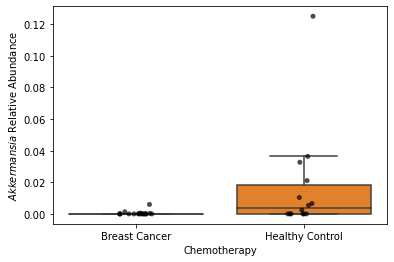

In [310]:
ax = sns.boxplot(x=metadata["Chemotherapy"],
                y=L6[akker],
                showfliers=False)

sns.stripplot(x=metadata["Chemotherapy"],
              y=L6[akker],
              palette=["black"]*2,
              alpha=0.7,
              ax=ax)

ax.set_ylabel(r"$Akkermansia$ Relative Abundance")

plt.savefig("Figures/Akkermansia-boxplot.pdf")
plt.show()

In [311]:
kruskal(L6.loc[metadata["Chemotherapy"]=="Breast Cancer",akker],
        L6.loc[metadata["Chemotherapy"]=="Healthy Control",akker])

KruskalResult(statistic=5.518042867440461, pvalue=0.01882130426578598)